**Tenemos datos estandarizados de la Oferta de casas en el 2019 y el 2020**

Usaremos solo los datos del 2020 para hacer un modelo cotizador de casas. 

In [254]:
import missingno as ms
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns

data_2020 = pd.read_csv('../data/casas_2020.csv')
data_2020.drop(data_2020[data_2020['latitud'].isna() == True].index,axis=0,inplace=True)

#Solo trabajremos con los datos de lima.
lima_mask = data_2020['Ciudad'].str.contains('Lima|Callao|Cañete').astype('boolean')
lima_data = data_2020[lima_mask]

lima_data.drop_duplicates(inplace=True) #Eliminamos duplicados

In [255]:
text_for_embeddings = lima_data[['Direccion','Descripcion']]  #Podemos buscar en el texto datos faltantes.

lima_data.drop(['Direccion','Descripcion'],axis=1, inplace=True)
lima_data.drop(lima_data[lima_data['Precio'].isna() ==True].index, axis=0, inplace=True)

#Creando nuevos features para datos Nulos.
lima_data['Barrio'].fillna('NoEspecifica', inplace=True)

#Eliminar todos las casas sin área
no_area_index = lima_data[(np.where(lima_data[['Area_constr','Area_total']].isnull().all(1),True,False))].index
lima_data.drop(no_area_index,inplace=True)

In [256]:
#Limpiando Precio y cambiando la moneda
TIPO_DE_CAMBIO = 3.5

lima_data['Precio'] = lima_data['Precio'].str.extract('(\d+)').astype('float32')
mask_usd = (lima_data['MONEDA'] == 'USD')

index_casas_usd = lima_data[mask_usd].index
lima_data.loc[mask_usd,'Precio'] = lima_data.loc[mask_usd,'Precio']*TIPO_DE_CAMBIO

lima_data.dropna(subset=['Precio'],axis=0,inplace=True) #Algunas casas solo tenían la moneda funcional, pero no el precio en sí.

In [269]:
#Reemplazo nulos en Area total y Area constr
for tupla_col in [('Area_total','Area_constr'),('Area_constr','Area_total')]:
    area_total_null = lima_data[lima_data[tupla_col[0]].isna()].index
    lima_data.loc[area_total_null,tupla_col[0]] = lima_data.loc[area_total_null, tupla_col[1]]

In [300]:
lima_data['Precio_m2_total'] = lima_data['Precio'] / lima_data['Area_total']
lima_data['Precio_m2_constr'] = lima_data['Precio'] / lima_data['Area_constr']

<AxesSubplot:>

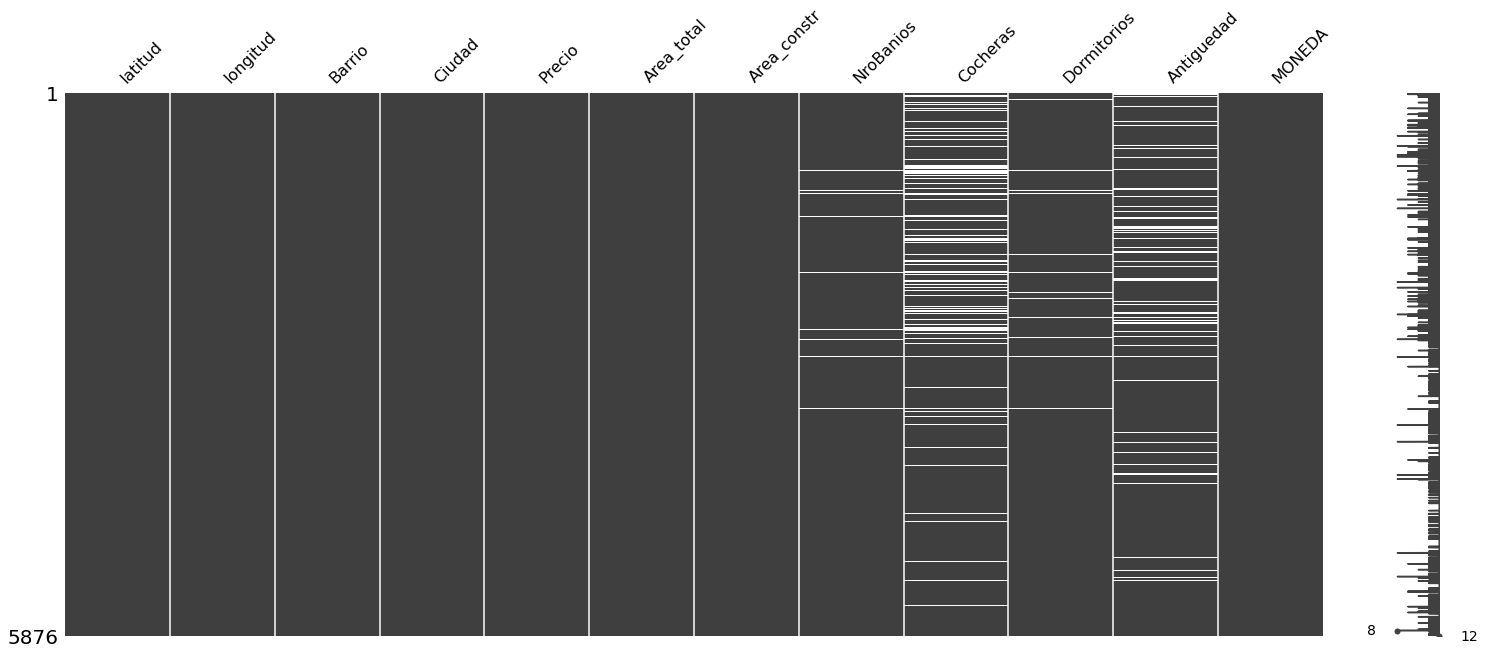

In [271]:
ms.matrix(lima_data)

###### Antes de imputar, exploraré los datos:

In [345]:
from scipy.stats import zscore
drop_ones = lima_data[lima_data['Precio'] < 10].index
lima_data.drop(drop_ones, axis=0, inplace=True)

#Los demás son metros por área cuandrada
datos_metros_2 = lima_data[lima_data['Precio'] < 65801.0].index

lima_data.loc[datos_metros_2, 'Precio'] = lima_data.loc[datos_metros_2, 'Precio']*lima_data.loc[datos_metros_2, 'Area_total']

In [376]:
expensive_outliers = lima_data[(zscore(lima_data['Precio']) > 3)].index
lima_data.drop(expensive_outliers, axis=0,inplace=True)

larger_outliers = lima_data[(zscore(lima_data['Area_total'])>2.5)].index
lima_data.drop(larger_outliers,axis=0, inplace=True)

#For Plotting
temporal_drop = lima_data[(lima_data['Area_total']>1000)].index

In [392]:
lima_data['Precio_cat'] = pd.cut(lima_data['Precio'],bins=4, labels =['bajo','medio','caro','muy caro'])

In [395]:
seven_first = lima_data['Barrio'].value_counts().iloc[0:7].keys().tolist()
lima_data['Barrio'].isin(seven_first)

0        True
1        True
2        True
3       False
4       False
        ...  
7852    False
7853     True
7854     True
7855     True
7858     True
Name: Barrio, Length: 5622, dtype: bool

Text(0.5, 1.0, 'Distritos x Area total x Categoría de Precios')

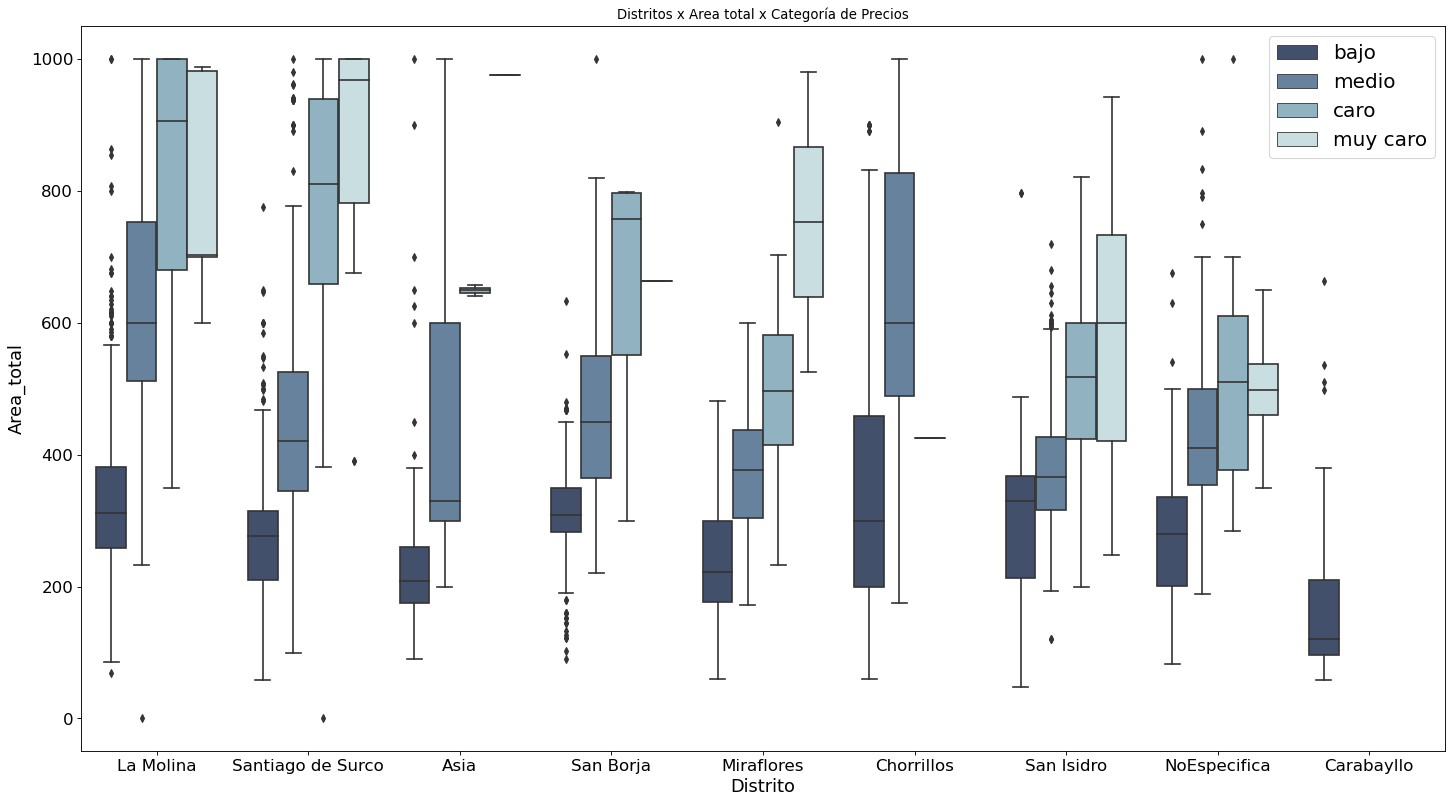

In [420]:
# BoxPlots para los 7 primeros distritos
from matplotlib.pyplot import figure

figure(figsize=(22, 12), dpi=80)

seven_first = lima_data['Barrio'].value_counts().iloc[0:9].keys().tolist()
ax = sns.boxplot(x="Barrio", y="Area_total", hue="Precio_cat", 
                 data=lima_data.drop(temporal_drop)[lima_data.drop(temporal_drop)['Barrio'].isin(seven_first)],
                palette="ch:r=-.2,d=.3_r")

ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(prop=dict(size=18))
ax.set_xlabel(r'Distrito', fontsize=16)

ax.set_ylabel(r'Area_total', fontsize=16)
ax.set_title(r'Distritos x Area total x Categoría de Precios')

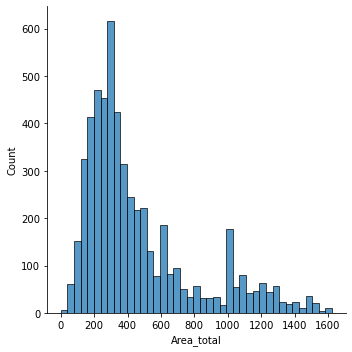

In [387]:
sns.displot(lima_data[lima_data['Area_total']<lima_data['Area_total'].quantile(.97)]['Area_total'])

<AxesSubplot:xlabel='Precio', ylabel='Area_total'>

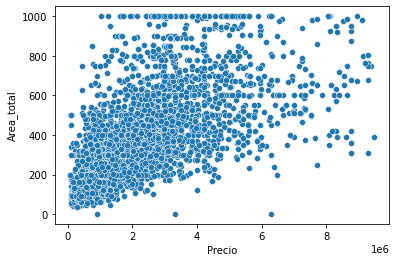

In [386]:
sns.scatterplot(x='Precio',y='Area_total', data = lima_data.drop(temporal_drop,axis=0))

In [285]:
#Limpio outliers con threshold de .98
threshold = lima_data['Area_total'].quantile(.98)
threshold

2896.5